In [1]:
import cv2
import time
import serial
from matplotlib import pyplot as plt, patches

import torch
import torchvision
import yolov1

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
%matplotlib notebook

In [2]:
# arduino = serial.Serial(port='/dev/cu.usbmodem11101', baudrate=9600, timeout=1)
# time.sleep(2)

# while True:
#     servo_pos = input("Enter a number: ")
#     servo_pos = str.encode(str(int(servo_pos)))
#     arduino.write(servo_pos)
#     time.sleep(1)
#     print(servo_pos)

In [2]:
def write_arduino(x):
    servo_pos = str.encode(str(int(x)))
    arduino.write(servo_pos)

In [3]:
model = yolov1.Yolo(
    split_size=7,
    n_bboxes=2,
    n_classes=1
)
model.load_state_dict(torch.load('./yolo_model2.pt', map_location=DEVICE))
model.to(DEVICE)

arduino = serial.Serial(port='/dev/cu.usbmodem11101', baudrate=9600, write_timeout=0.01)

In [4]:
common_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((448, 448)),
        torchvision.transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    ])

# with torch.inference_mode():
#     example_gpu = example.unsqueeze(dim=0).to(DEVICE)
#     predicted_label = model(example_gpu)
#     predicted_label = predicted_label.cpu().view(-1, 7, 7, 11)
# fig, ax = plt.subplots(1, 1, figsize=(9, 6))
# ax.imshow(example.permute(1, 2, 0))
# for i in range(7):
#     for j in range(7):
#         for anchor in [1, 6]:
#             if predicted_label[0, i, j, anchor] > 0.25:
#                 x, y, width, height = predicted_label[0, i, j, anchor + 1: anchor + 5]
#                 rectangle_x = (x + j - width / 2) * example.shape[2] / 7
#                 rectangle_y = (y + i - height / 2) * example.shape[1] / 7
#                 rectangle = patches.Rectangle(
#                     (rectangle_x, rectangle_y),
#                     width * example.shape[2] / 7, height * example.shape[1] / 7,
#                     linewidth=2, edgecolor='r', facecolor="none"
#                 )
#                 ax.add_patch(rectangle)
# plt.axis(False)
# plt.show();

<IPython.core.display.Javascript object>


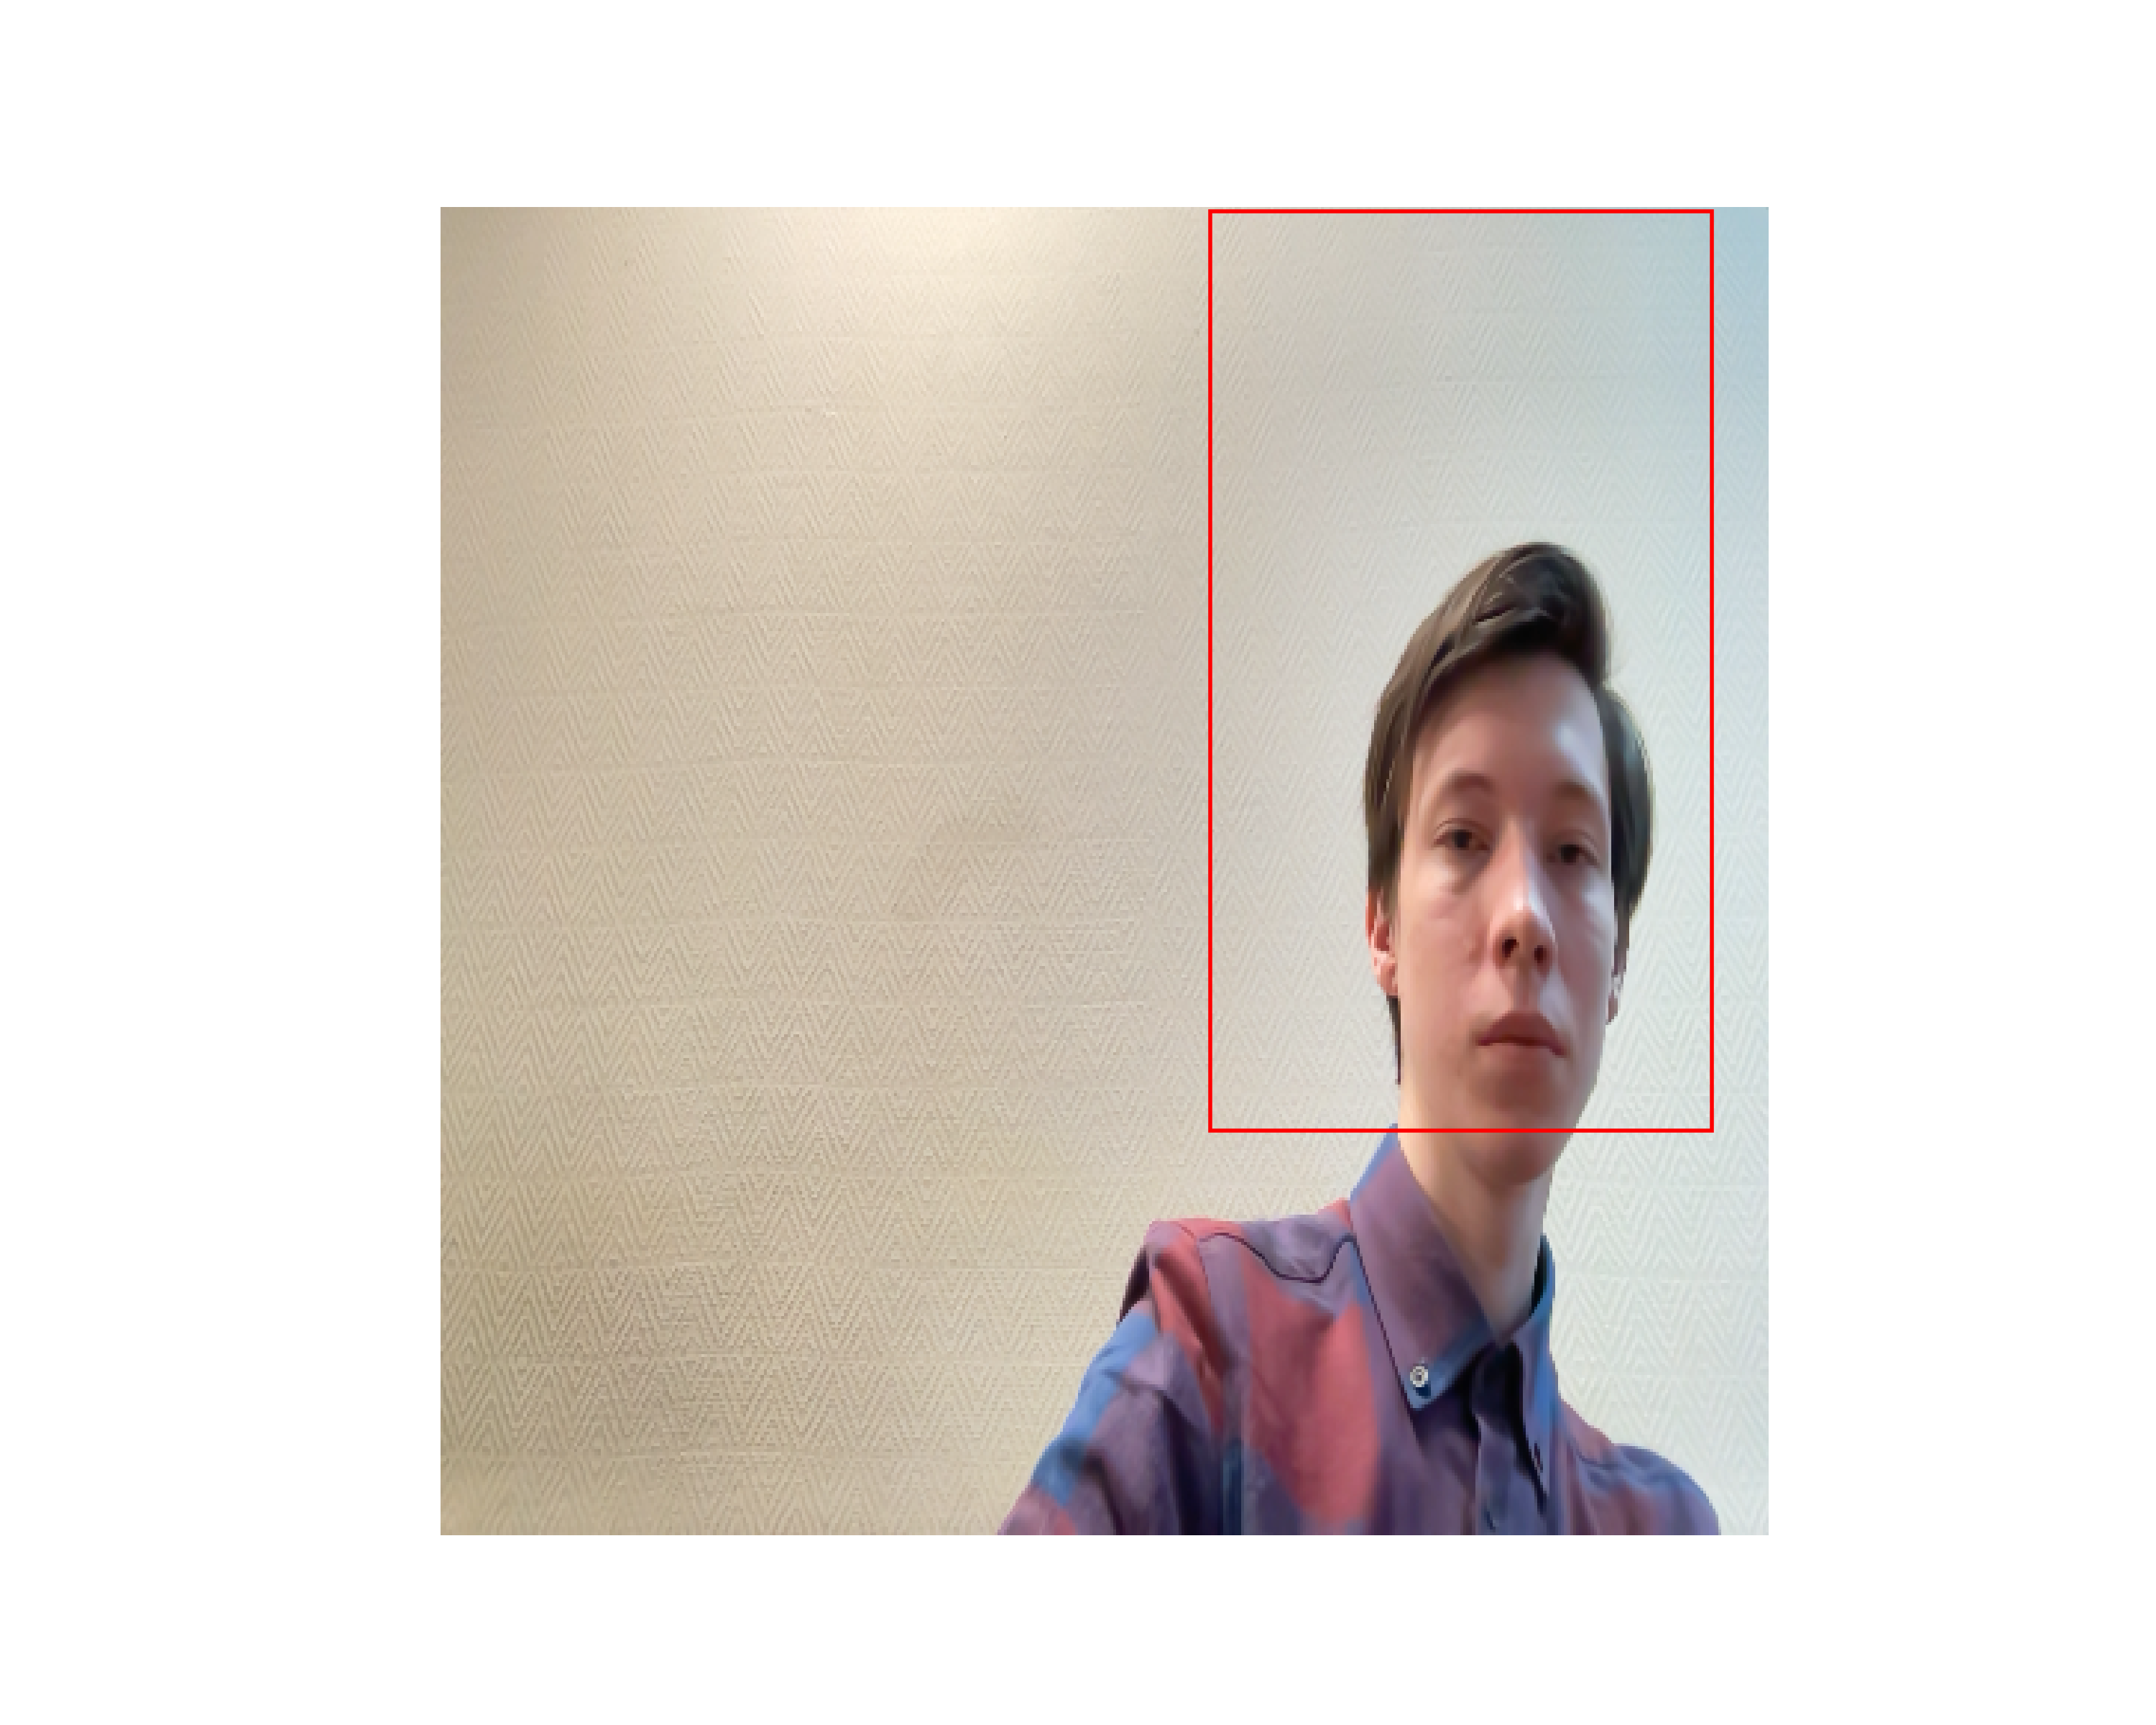

112
90
91
137
82
122
47
50
52
65
112
116


KeyboardInterrupt: 

In [9]:
vid = cv2.VideoCapture(0)
ret, frame = vid.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame_tensor = common_transforms(frame)

fig, ax = plt.subplots(figsize=(15, 12))
plt.ion()
plt.axis(False)
initial_image = ax.imshow((frame_tensor.permute(1, 2, 0) * 0.5 + 0.5).numpy())
initial_rectangle = ax.add_patch(
    patches.Rectangle((0, 0), 0, 0, linewidth=2, edgecolor='r', facecolor="none")
)


for value in range(150):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_tensor = common_transforms(frame).unsqueeze(dim=0).to(DEVICE)
    model.eval()
    with torch.inference_mode():
        predicted_label = model(frame_tensor)
        predicted_label = predicted_label.cpu().view(-1, 7, 7, 11)
    max_probability = 0.0
    for i in range(7):
        for j in range(7):
            for anchor in [1, 6]:
                if predicted_label[0, i, j, anchor].item() > max_probability:
                    max_probability = predicted_label[0, i, j, anchor].item()
                    x, y, width, height = predicted_label[0, i, j, anchor + 1:anchor + 5]
                    grid_cell = (i, j)
#     write_arduino(str(180 - int(x * 180)))
#     write_arduino(str(int(x * 180)))
    servo_angle = int(x * 180)
    print(servo_angle + 50)
    if servo_angle > 0:
        pass
        write_arduino(str(max(180, servo_angle + 50)))
    else:
        continue
#     print()
#     print(str(180 - int(x * 180)))
    rectangle_x = (x + grid_cell[1] - width / 2) * frame_tensor.shape[2] / 7
    rectangle_y = (y + grid_cell[0] - height / 2) * frame_tensor.shape[1] / 7
    initial_rectangle.set_x(rectangle_x)
    initial_rectangle.set_y(rectangle_y)
    initial_rectangle.set_width(width * frame_tensor.shape[2] / 7)
    initial_rectangle.set_height(height * frame_tensor.shape[3] / 7)
    initial_image.set_data(
#         cv2.cvtColor(
            (frame_tensor[0].permute(1, 2, 0) * 0.5 + 0.5).numpy()# , cv2.COLOR_BGR2RGB
#         )
    )
#    initial_image.set_data(frame_tensor[0].permute(1, 2, 0) * 0.5 + 0.5)
#    initial_image.set_data(frame)

    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(1)
plt.show();